In [84]:
import pandas as pd
from dataset_manager import DatasetManager
import seaborn as sns
from matplotlib import pyplot as plt


dataset_path = "./datasets"
manager = DatasetManager(dataset_path)

In [128]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 0)



In [2]:
manager.prepare_dataset()

06-01 22:04 - DatasetManager - prepare_dataset - INFO - Preparing riotransparente_despesas_ato_2015 ...
06-01 22:04 - DatasetManager - prepare_dataset - INFO - riotransparente_despesas_ato_2015 is ready to use!
06-01 22:04 - DatasetManager - prepare_dataset - INFO - Preparing riotransparente_despesas_2015 ...
06-01 22:04 - DatasetManager - prepare_dataset - INFO - riotransparente_despesas_2015 is ready to use!
06-01 22:04 - DatasetManager - prepare_dataset - INFO - Preparing riotransparente_despesas_ato_2018 ...
06-01 22:04 - DatasetManager - prepare_dataset - INFO - riotransparente_despesas_ato_2018 is ready to use!
06-01 22:04 - DatasetManager - prepare_dataset - INFO - Preparing censo_rj_familias_2000 ...
06-01 22:04 - DatasetManager - prepare_dataset - INFO - censo_rj_familias_2000 is ready to use!
06-01 22:04 - DatasetManager - prepare_dataset - INFO - Preparing riotransparente_contratos_2016 ...
06-01 22:04 - DatasetManager - prepare_dataset - INFO - riotransparente_contratos_201

In [3]:
dataset = manager.get_dataset("riotransparente_contratos_2017")

In [5]:
df = dataset.load_as_pandas(error_bad_lines=False, encoding='latin-1', sep=";")

# 1 - Listando Colunas

In [29]:
df.columns

Index(['Ano instrumento', 'Nr instrumento', 'Situação', 'Espécie',
       'Código favorecido', 'Favorecido', 'Processo instrutivo',
       'Data início previsto', 'Data fim previsto', 'Programa de trabalho',
       'Fonte de recursos', 'Descrição da fonte de recursos', 'Objeto',
       'Modalidade de licitação', 'Fundamentação Legal',
       'Valor inicial do instrumento', 'Valor do acréscimo ou redução',
       'Valor atualizado do instrumento', 'Saldo a executar do instrumento',
       'Valor empenhado', 'Valor liquidado', 'Valor pago',
       'Data da assinatura', 'Data do encerramento', 'Órgão executor',
       'Descrição do órgão executor', 'Unidade orçamentária executora',
       'Descrição da unidade orçamentária executora', 'Programa',
       'Descrição de programa', 'Categoria Econômica',
       'Descrição da categoria econômica', 'Grupo de despesa',
       'Descrição de grupo de despesa ', 'Elemento de despesa',
       'Descrição do elemento de despesa', 'Modalidade de aplica

Elementos da coluna `Descrição da fonte de recursos`

In [31]:
df["Descrição da fonte de recursos"].unique()

array(['OPERACOES DE CREDITO CONTRATUAIS REALIZADAS', nan, 'FUNDEB',
       'TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR',
       'ORDINARIOS NAO VINCULADOS',
       'ATENCAO DE MEDIA E ALTA COMPLEXIDADE AMBULATORIAL E HOSPITALAR',
       'ATENCAO DE MEDIA E ALTA COMPLEXIDADE AMBULATORIAL E HOSPITALAR - EXERCICIOS ANTERIORES',
       'ATENCAO BASICA', 'CONVENIOS', 'OUTRAS - EXERCICIOS ANTERIORES',
       'INCENTIVO A CULTURA',
       'RECEITA PROPRIA DE AUTARQUIAS, FUNDACOES E EMPRESAS',
       'CONVENIO REALIZADO - EXERCICIOS ANTERIORES',
       'MULTAS POR INFRACAO A LEGISLACAO DO TRANSITO',
       'CONTRAPARTIDA - REGULARIZACAO DE OBRAS', 'CONVENIO REALIZADO',
       'INCENTIVO A CULTURA - EXERCICIOS ANTERIORES',
       'ROYALTIES DO PETROLEO',
       'CONTRAPARTIDA - REGULARIZACAO DE OBRAS - EXERCICIOS ANTERIORES',
       'TRANSFERENCIA DO FUNDO NACIONAL E ESTADUAL DE ASSISTENCIA SOCIAL - EXERCICIOS ANTERIORES',
       'MULTAS POR INFRACAO A LEGISLACAO DE SAUDE', 'COSIP',

Filtro com base na Descrição `"TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR"`

In [54]:
df_merenda = df[df["Descrição da fonte de recursos"] == "TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR"]
df_merenda

,Ano instrumento,Nr instrumento,Situação,Espécie,Código favorecido,Favorecido,Processo instrutivo,Data início previsto,Data fim previsto,Programa de trabalho,...,Tipo Administração,Dir Ind,Exercício origem,Instrumento Origem,Número do processo de origem,Órgão executor de origem,Descrição do órgão executor de origem,Novo codigo do favorecido,Novo favorecido,Data da mudança
6,2017,145,ENCERRADO,Convênio,33726472000266,SOC DE ASSISTENCIA E CULTURA SAGRADO CORACAO D...,7.004066e+10,05/09/2017,30/06/2018,16.01.12.306.9000.5030,...,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2017,167,ENCERRADO,Convênio,30717177000174,ASSOCIACAO DOS MORADORES DO MORRO DO ALEMAO,7.004846e+10,15/09/2017,30/06/2018,16.01.12.306.9000.5030,...,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2017,181,ENCERRADO,Convênio,31157092000141,SOCIEDADE BENEFICENTE SAGRADO CORACAO DE MARIA,7.004730e+10,26/09/2017,30/06/2018,16.01.12.306.9000.5030,...,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2017,217,ENCERRADO,Convênio,2717198000154,NUCLEO DE ACAO COMUNITARIA E DE DESENVOLVIMENT...,7.004579e+10,17/10/2017,30/06/2018,16.01.12.306.9000.5030,...,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2017,230,ENCERRADO,Convênio,3881480000135,ABRINDO PORTAS SOCIEDADE CIVIL,7.005947e+10,09/11/2017,30/06/2018,16.01.12.306.9000.5030,...,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2017,262,ENCERRADO,Convênio,34031807000103,CENTRO ESPIRITA CRISTOFILOS,7.005747e+10,08/12/2017,30/06/2018,16.01.12.306.9000.5030,...,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2017,268,ENCERRADO,Convênio,29061900000120,SOC.INDEPENDENTE DE CULT.E APREND.DE MANGUINHOS,7.006051e+10,19/12/2017,30/06/2018,16.01.12.306.9000.5030,...,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,2017,97,ENCERRADO,Convênio,34056630000108,CRUZADA PELA INFANCIA DO LEME,7.003969e+10,09/08/2017,30/06/2018,16.01.12.306.9000.5030,...,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,2017,126,ENCERRADO,Convênio,34036194000105,CASA ESPIRITA CRISTA MARIA DE NAZARE,7.004063e+10,24/08/2017,30/06/2018,16.01.12.306.9000.5030,...,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,2017,160,ENCERRADO,Convênio,29270428000136,GRUPO COMUNITARIO MARIA MARIA,7.004566e+10,12/09/2017,30/06/2018,16.01.12.306.9000.5030,...,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Muitas linhas na coluna `Descrição do órgão executor` são nulas. 
Vamos ver quais valores estão diferentes de nulo nessa coluna

In [55]:
df_merenda['Descrição do órgão executor'].unique()

array(['SECRETARIA MUNICIPAL DE EDUCAÇÃO',
       '5A. COORDENADORIA REGIONAL DE EDUCAÇÃO'], dtype=object)

**Esse dados parece correto! De fato apenas os orgão voltados a educação deveriam gerenciar o recuso da Merenda escolar**

Vamos ver os favorecidos e os valores pagos

In [56]:
df_merenda[[
    'Favorecido',
    'Valor inicial do instrumento',
    'Valor do acréscimo ou redução',
    'Valor atualizado do instrumento',
    'Saldo a executar do instrumento',
    'Valor empenhado',
    'Valor liquidado',
    'Valor pago']]

,Favorecido,Valor inicial do instrumento,Valor do acréscimo ou redução,Valor atualizado do instrumento,Saldo a executar do instrumento,Valor empenhado,Valor liquidado,Valor pago
6,SOC DE ASSISTENCIA E CULTURA SAGRADO CORACAO D...,"21784,00",",00","21784,00",",00","21784,00","21784,00","21784,00"
7,ASSOCIACAO DOS MORADORES DO MORRO DO ALEMAO,"19902,00",",00","19902,00",",00","19902,00","19902,00","19902,00"
8,SOCIEDADE BENEFICENTE SAGRADO CORACAO DE MARIA,"26750,00",",00","26750,00",",00","26750,00","26750,00","26750,00"
9,NUCLEO DE ACAO COMUNITARIA E DE DESENVOLVIMENT...,"42800,00",",00","42800,00",",00","42800,00","42800,00","42800,00"
10,ABRINDO PORTAS SOCIEDADE CIVIL,"24610,00",",00","24610,00",",00","24610,00","24610,00","24610,00"
12,CENTRO ESPIRITA CRISTOFILOS,"10700,00",",00","10700,00",",00","10700,00","10700,00","10700,00"
13,SOC.INDEPENDENTE DE CULT.E APREND.DE MANGUINHOS,"15194,00",",00","15194,00",",00","15194,00","15194,00","15194,00"
123,CRUZADA PELA INFANCIA DO LEME,"13910,00",",00","13910,00",",00","13910,00","13910,00","13910,00"
125,CASA ESPIRITA CRISTA MARIA DE NAZARE,"25894,00",",00","25894,00",",00","25894,00","25894,00","25894,00"
127,GRUPO COMUNITARIO MARIA MARIA,"15408,00",",00","15408,00",",00","15408,00","15408,00","15408,00"


Agora, vamos analisar um histograma dos valores pagos

In [74]:
def cast_serie_to_float(serie):
    return serie.apply(lambda x: float(x.replace(",",".")))
    
df_merenda.loc[:,"Valor pago_fmt"] = cast_serie_to_float(df_merenda["Valor pago"])

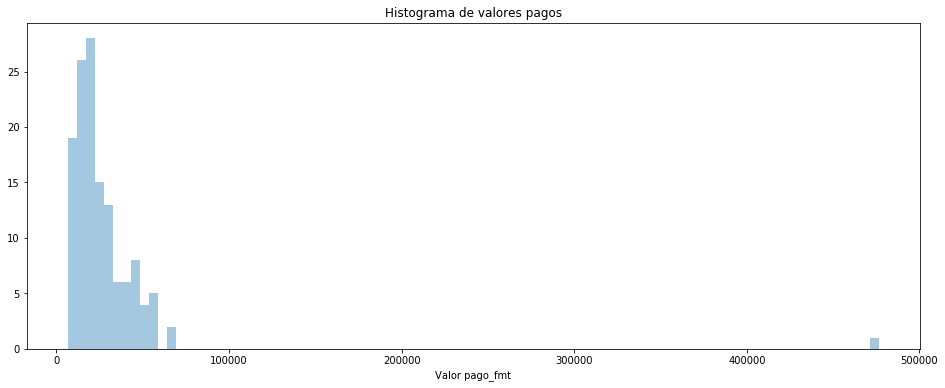

In [89]:
plt.figure(figsize=(16, 6))
valor_pago_plot = sns.distplot(df_merenda["Valor pago_fmt"], kde=False, bins=90)
valor_pago_plot.set_title("Histograma de valores pagos")
valor_pago_plot;

Pelo histograma podemos ver que a maioria dos favorecidos recebe menos que R$100000,00.
Entretanto, os valores pagos são referentes a um período de dias. Vamos analisar agora quantos Dias cada processo tem.

In [117]:
df_merenda.loc[:,'Data início previsto_fmt']=pd.to_datetime(df_merenda['Data início previsto'])
df_merenda.loc[:,'Data fim previsto_fmt']=pd.to_datetime(df_merenda['Data fim previsto'])

df_merenda.loc[:,'Data da assinatura_fmt']=pd.to_datetime(df_merenda['Data da assinatura'])
df_merenda.loc[:,'Data do encerramento_fmt']=pd.to_datetime(df_merenda['Data do encerramento'])


In [118]:
df_merenda.loc[:,'Dias previstos'] = (df_merenda['Data fim previsto_fmt'] - df_merenda['Data início previsto_fmt']).dt.days
df_merenda.loc[:,'Dias assinatura_encerramento'] = (df_merenda['Data do encerramento_fmt'] - df_merenda['Data da assinatura_fmt']).dt.days


O histograma abaixo mostra os dis previstos do contrato

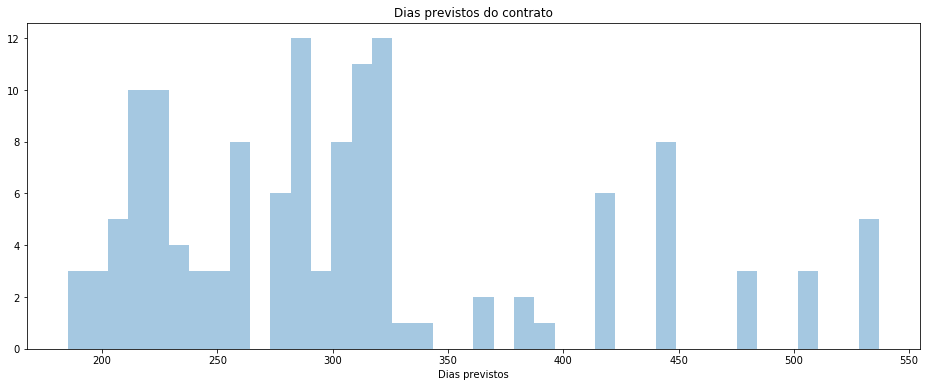

In [154]:
plt.figure(figsize=(16, 6))
plt_dias_previstos = sns.distplot(df_merenda['Dias previstos'], bins=40, kde=False)
plt_dias_previstos.set_title("Dias previstos do contrato")
plt_dias_previstos;

O histograma abaixo mostra quantos dias passaram desde a assinatura até o final do contrato

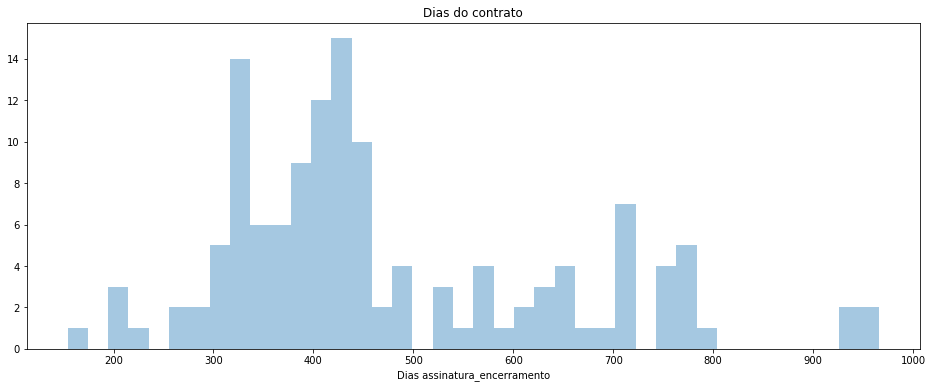

In [155]:
plt.figure(figsize=(16, 6))
plt_dias_contrato = sns.distplot(df_merenda['Dias assinatura_encerramento'], bins=40, kde=False)
plt_dias_contrato.set_title("Dias do contrato")
plt_dias_contrato;

In [129]:
df_merenda[df_merenda["Valor pago_fmt"]>400000]

,Ano instrumento,Nr instrumento,Situação,Espécie,Código favorecido,Favorecido,Processo instrutivo,Data início previsto,Data fim previsto,Programa de trabalho,Fonte de recursos,Descrição da fonte de recursos,Objeto,Modalidade de licitação,Fundamentação Legal,Valor inicial do instrumento,Valor do acréscimo ou redução,Valor atualizado do instrumento,Saldo a executar do instrumento,Valor empenhado,Valor liquidado,Valor pago,Data da assinatura,Data do encerramento,Órgão executor,Descrição do órgão executor,Unidade orçamentária executora,Descrição da unidade orçamentária executora,Programa,Descrição de programa,Categoria Econômica,Descrição da categoria econômica,Grupo de despesa,Descrição de grupo de despesa,Elemento de despesa,Descrição do elemento de despesa,Modalidade de aplicação,Descrição da modalidade de aplicação,Natureza da despesa,Descrição da natureza da despesa,Poder,Tipo Administração,Dir Ind,Exercício origem,Instrumento Origem,Número do processo de origem,Órgão executor de origem,Descrição do órgão executor de origem,Novo codigo do favorecido,Novo favorecido,Data da mudança,Valor pago _fmt,Valor pago_fmt,Data início previsto_fmt,Data fim previsto_fmt,Dias previstos,Data da assinatura_fmt,Data do encerramento_fmt,Dias assinatura_encerramento
1495,2017,10,ENCERRADO,Contrato,72223829000164,UNIAO DAS ASSOCIACOES E COOPERATIVAS USUARIAS DO PAVILHAO 30,7.050021e+12,15/12/2017,14/12/2018,16.06.12.306.0316.2136,115.0,TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR,AQUISIÇÃO DE GÊNEROS ALIMENTÍCIOS PARA O PROGRAMA DE ALIMENTAÇÃO ESCOLAR,Dispensa,ARTIGO 24 INCISO XXX DA LEI 8666 DE 21/06/93 E SUAS ALTERACOES,"617067,32",",00","617067,32","140393,32","476674,00","476674,00","476674,00",15/12/2017,25/01/2019,1606,5A. COORDENADORIA REGIONAL DE EDUCAÇÃO,1606.0,5ª COORDENADORIA REGIONAL DE EDUCAÇÃO,316.0,MELHORIA DA QUALIDADE DA EDUCACAO CARIOCA,3.0,DESPESAS CORRENTES,3.0,OUTRAS DESPESAS CORRENTES,30.0,MATERIAL DE CONSUMO,90.0,APLICACOES DIRETAS,33903007.0,"GENEROS ALIMENTICIOS, INCLUSIVE BEBIDAS - MERENDA",EXECUTIVO,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,476674.0,2017-12-15,2018-12-14,364,2017-12-15,2019-01-25,406


O filtro a cima mostra que o Favorecido recebeu um Valor maios que outros. Este favorecido recebeu mais de R$400000,00 para operar 406, enquanto pela distribuição dos dias, podemos ver que a maioria não recebe esse valor para operar essa quantidade de dias. 

Esse valor só seria coerente se o Favorecido oferecesse um serviço muito maior/melhor que os outros.

Esse Favorecido ainda não recebeu todo valor inicial. Vamos agora analisar se isso é algo comum.

Abaixo iremos analisar quantos Favorecidos recebem valores diferentes do valor inicial

In [131]:
df_merenda.loc[:,"Valor inicial do instrumento_fmt"] = cast_serie_to_float(df_merenda["Valor inicial do instrumento"])

In [141]:
df_merenda.loc[:,"diferenca de valores"] = df_merenda["Valor inicial do instrumento_fmt"] - df_merenda["Valor pago_fmt"]

In [142]:
df_merenda[df_merenda["diferenca de valores"] != 0.0 ]

,Ano instrumento,Nr instrumento,Situação,Espécie,Código favorecido,Favorecido,Processo instrutivo,Data início previsto,Data fim previsto,Programa de trabalho,Fonte de recursos,Descrição da fonte de recursos,Objeto,Modalidade de licitação,Fundamentação Legal,Valor inicial do instrumento,Valor do acréscimo ou redução,Valor atualizado do instrumento,Saldo a executar do instrumento,Valor empenhado,Valor liquidado,Valor pago,Data da assinatura,Data do encerramento,Órgão executor,Descrição do órgão executor,Unidade orçamentária executora,Descrição da unidade orçamentária executora,Programa,Descrição de programa,Categoria Econômica,Descrição da categoria econômica,Grupo de despesa,Descrição de grupo de despesa,Elemento de despesa,Descrição do elemento de despesa,Modalidade de aplicação,Descrição da modalidade de aplicação,Natureza da despesa,Descrição da natureza da despesa,Poder,Tipo Administração,Dir Ind,Exercício origem,Instrumento Origem,Número do processo de origem,Órgão executor de origem,Descrição do órgão executor de origem,Novo codigo do favorecido,Novo favorecido,Data da mudança,Valor pago _fmt,Valor pago_fmt,Data início previsto_fmt,Data fim previsto_fmt,Dias previstos,Data da assinatura_fmt,Data do encerramento_fmt,Dias assinatura_encerramento,Valor inicial do instrumento_fmt,diferenca de valores
987,2017,178,ENCERRADO,Convênio,92873413000441,ASSOCIACAO FILHAS DE SANTA MARIA DA PROVIDENCIA,7.005110e+10,21/09/2017,30/06/2018,16.01.12.306.9000.5030,115.0,TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR,TRANSFERÊNCIA DE RECURSOS DO PNAE/FNDE/MEC,NaN,NaN,"55752,00","-3672,00","52080,00",",00","52080,00","52080,00","52080,00",21/09/2017,06/11/2018,1600,SECRETARIA MUNICIPAL DE EDUCAÇÃO,1601.0,GABINETE DO SECRETÁRIO MUNICIPAL DE EDUCAÇÃO,9000.0,GESTAO DAS OPERACOES ESPECIAIS,3.0,DESPESAS CORRENTES,3.0,OUTRAS DESPESAS CORRENTES,41.0,CONTRIBUICOES,50.0,TRANSFERENCIAS A INSTITUICOES PRIVADAS SEM FINS LUCRATIVOS,33504101.0,CONTRIBUICOES,EXECUTIVO,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,52080.00,2017-09-21,2018-06-30,282,2017-09-21,2018-06-11,263,55752.00,3672.00
1301,2017,5,ENCERRADO,Contrato,72223829000164,UNIAO DAS ASSOCIACOES E COOPERATIVAS USUARIAS DO PAVILHAO 30,7.050014e+12,01/08/2017,31/01/2018,16.06.12.306.0316.2136,115.0,TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR,AQUISIÇÃO DE GÊNERO ALIMENTÍCIOS DA AGRICULTURA FAMILIAR PARA ALIMENTAÇÃO ESCOLAR,Dispensa,ARTIGO 24 INCISO XII DA LEI 8666 DE 21/06/93 E SUAS ALTERACOES,"286916,54",",00","286916,54","237141,52","49775,02","49775,02","49775,02",01/08/2017,11/05/2018,1606,5A. COORDENADORIA REGIONAL DE EDUCAÇÃO,1606.0,5ª COORDENADORIA REGIONAL DE EDUCAÇÃO,316.0,MELHORIA DA QUALIDADE DA EDUCACAO CARIOCA,3.0,DESPESAS CORRENTES,3.0,OUTRAS DESPESAS CORRENTES,30.0,MATERIAL DE CONSUMO,90.0,APLICACOES DIRETAS,33903007.0,"GENEROS ALIMENTICIOS, INCLUSIVE BEBIDAS - MERENDA",EXECUTIVO,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,49775.02,2017-01-08,2018-01-31,388,2017-01-08,2018-11-05,666,286916.54,237141.52
1495,2017,10,ENCERRADO,Contrato,72223829000164,UNIAO DAS ASSOCIACOES E COOPERATIVAS USUARIAS DO PAVILHAO 30,7.050021e+12,15/12/2017,14/12/2018,16.06.12.306.0316.2136,115.0,TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR,AQUISIÇÃO DE GÊNEROS ALIMENTÍCIOS PARA O PROGRAMA DE ALIMENTAÇÃO ESCOLAR,Dispensa,ARTIGO 24 INCISO XXX DA LEI 8666 DE 21/06/93 E SUAS ALTERACOES,"617067,32",",00","617067,32","140393,32","476674,00","476674,00","476674,00",15/12/2017,25/01/2019,1606,5A. COORDENADORIA REGIONAL DE EDUCAÇÃO,1606.0,5ª COORDENADORIA REGIONAL DE EDUCAÇÃO,316.0,MELHORIA DA QUALIDADE DA EDUCACAO CARIOCA,3.0,DESPESAS CORRENTES,3.0,OUTRAS DESPESAS CORRENTES,30.0,MATERIAL DE CONSUMO,90.0,APLICACOES DIRETAS,33903007.0,"GENEROS ALIMENTICIOS, INCLUSIVE BEBIDAS - MERENDA",EXECUTIVO,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,476674.00,2017-12-15,2018-12-14,364,2017-12-15,2019-01-25,406,617067.32,140393.32


A cima vemos que existem apenas 3 Favorecidos que não receberam o mesmo valor do valor inicial.
2 dos 3 são na verdade o mesmo Favorecido, mas com contratos diferentes. 

Vamos agrupar os valores por favorecidos e entender melhor o quanto foi pago para cada um.

In [145]:
df_merenda.groupby?

In [147]:
df_merenda_grouped = df_merenda.groupby(["Favorecido", "Código favorecido", "Descrição do órgão executor"], as_index=False).sum()

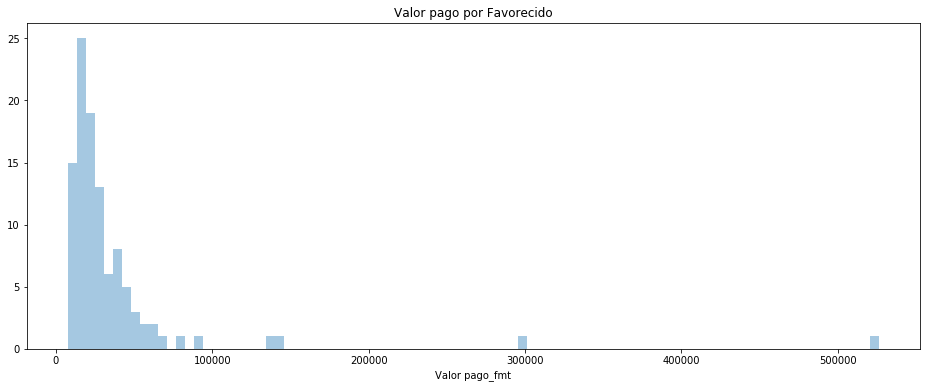

In [150]:
plt.figure(figsize=(16, 6))
merenda_grouped_plot = sns.distplot(df_merenda_grouped["Valor pago_fmt"],  kde=False, bins=90)
merenda_grouped_plot.set_title("Valor pago por Favorecido")
merenda_grouped_plot;

O Grafico a cima não mostra grande diferença do outro histograma sobre o Valor pago, exceto alguns Favorecidos, que quando os valores pagos são somados aparecem como outliers.

In [152]:
df_merenda_grouped[df_merenda_grouped["Valor pago_fmt"]>100000]["Favorecido"]

88     MITRA ARQUIEPISCOPAL DO RIO DE JANEIRO                        
90     NUCLEO DE ACAO COMUNITARIA E DE DESENVOLVIMENTO SOCIAL NACODES
98     RIOSOLIDARIO OBRA SOCIAL DO RIO DE JANEIRO                    
104    UNIAO DAS ASSOCIACOES E COOPERATIVAS USUARIAS DO PAVILHAO 30  
Name: Favorecido, dtype: object

In [160]:
df_merenda[df_merenda["Favorecido"].str.contains("ESCOLA")]

,Ano instrumento,Nr instrumento,Situação,Espécie,Código favorecido,Favorecido,Processo instrutivo,Data início previsto,Data fim previsto,Programa de trabalho,Fonte de recursos,Descrição da fonte de recursos,Objeto,Modalidade de licitação,Fundamentação Legal,Valor inicial do instrumento,Valor do acréscimo ou redução,Valor atualizado do instrumento,Saldo a executar do instrumento,Valor empenhado,Valor liquidado,Valor pago,Data da assinatura,Data do encerramento,Órgão executor,Descrição do órgão executor,Unidade orçamentária executora,Descrição da unidade orçamentária executora,Programa,Descrição de programa,Categoria Econômica,Descrição da categoria econômica,Grupo de despesa,Descrição de grupo de despesa,Elemento de despesa,Descrição do elemento de despesa,Modalidade de aplicação,Descrição da modalidade de aplicação,Natureza da despesa,Descrição da natureza da despesa,Poder,Tipo Administração,Dir Ind,Exercício origem,Instrumento Origem,Número do processo de origem,Órgão executor de origem,Descrição do órgão executor de origem,Novo codigo do favorecido,Novo favorecido,Data da mudança,Valor pago _fmt,Valor pago_fmt,Data início previsto_fmt,Data fim previsto_fmt,Dias previstos,Data da assinatura_fmt,Data do encerramento_fmt,Dias assinatura_encerramento,Valor inicial do instrumento_fmt,diferenca de valores
131,2017,252,ENCERRADO,Convênio,30126791000161,CRECHE PRE ESCOLA COM DO 199 PINGO GENTE,7.006052e+10,27/11/2017,30/06/2018,16.01.12.306.9000.5030,115.0,TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR,TRANFERENCIA DOS RECURSOS FINANCEIROS PNAE/FNDE/MEC,NaN,NaN,"10700,00",",00","10700,00",",00","10700,00","10700,00","10700,00",27/11/2017,22/10/2018,1600,SECRETARIA MUNICIPAL DE EDUCAÇÃO,1601.0,GABINETE DO SECRETÁRIO MUNICIPAL DE EDUCAÇÃO,9000.0,GESTAO DAS OPERACOES ESPECIAIS,3.0,DESPESAS CORRENTES,3.0,OUTRAS DESPESAS CORRENTES,41.0,CONTRIBUICOES,50.0,TRANSFERENCIAS A INSTITUICOES PRIVADAS SEM FINS LUCRATIVOS,33504101.0,CONTRIBUICOES,EXECUTIVO,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10700.0,2017-11-27,2018-06-30,215,2017-11-27,2018-10-22,329,10700.0,0.0
132,2017,255,ENCERRADO,Convênio,31417686000144,CRECHE ESCOLA COMUNITARIA JARDIM SONHAR CONCEICAO,7.006385e+10,28/11/2017,30/06/2018,16.01.12.306.9000.5030,115.0,TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR,TRANSFERENCIA DOS RECURSOS FINACEIRO PNAE/FNDE/MEC,NaN,NaN,"25466,00",",00","25466,00",",00","25466,00","25466,00","25466,00",28/11/2017,29/10/2018,1600,SECRETARIA MUNICIPAL DE EDUCAÇÃO,1601.0,GABINETE DO SECRETÁRIO MUNICIPAL DE EDUCAÇÃO,9000.0,GESTAO DAS OPERACOES ESPECIAIS,3.0,DESPESAS CORRENTES,3.0,OUTRAS DESPESAS CORRENTES,41.0,CONTRIBUICOES,50.0,TRANSFERENCIAS A INSTITUICOES PRIVADAS SEM FINS LUCRATIVOS,33504101.0,CONTRIBUICOES,EXECUTIVO,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,25466.0,2017-11-28,2018-06-30,214,2017-11-28,2018-10-29,335,25466.0,0.0
234,2017,210,ENCERRADO,Convênio,1149568000131,CRECHE ESCOLA MIMI,7.004938e+10,10/10/2017,30/06/2018,16.01.12.306.9000.5030,115.0,TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR,TRANSFERENCIA DE RECURSOS DO PNAE/FNDE/MEC,NaN,NaN,"16050,00",",00","16050,00",",00","16050,00","16050,00","16050,00",10/10/2017,23/10/2018,1600,SECRETARIA MUNICIPAL DE EDUCAÇÃO,1601.0,GABINETE DO SECRETÁRIO MUNICIPAL DE EDUCAÇÃO,9000.0,GESTAO DAS OPERACOES ESPECIAIS,3.0,DESPESAS CORRENTES,3.0,OUTRAS DESPESAS CORRENTES,41.0,CONTRIBUICOES,50.0,TRANSFERENCIAS A INSTITUICOES PRIVADAS SEM FINS LUCRATIVOS,33504101.0,CONTRIBUICOES,EXECUTIVO,SECRETARIA,DIRETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,16050.0,2017-10-10,2018-06-30,263,2017-10-10,2018-10-23,378,16050.0,0.0
334,2017,244,ENCERRADO,Convênio,10945138000117,ESCOLA COMUNITARIA SOUZA PINTO,7.006223e+10,21/11/2017,30/06/2018,16.01.12.306.9000.5030,115.0,TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR,TRANSFERENCIA DE RECURSOS DO PNAE/FNDE/MEC,NaN,NaN,"21614,00",",00","21614,00",",00","21614,00","21614,00","21614,00",21/11/2017,06/12/2018,1600,SECRETARIA MUNICI